In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#c8abc9','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V3

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']

animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))

# act_directory = 'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'
act_directory = '..\\..\\Data\\Analysis_Cache'
ops_directory = '..\\..\\Data\\Opsin_Cache'
beh_directory = '..\\..\\Data\\Behavioor'

stdfont = 14
stdyfrac = 0.06

In [3]:
animals

array(['BS_40', 'BS_41', 'BS_42', 'BS_49', 'BS_50', 'BS_51', 'BS_56',
       'BS_59', 'BS_67', 'BS_70', 'BS_72', 'BS_87', 'BS_108', 'DS_15',
       'DS_19'], dtype='<U6')

In [4]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

In [ ]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)

C:\Users\4thgr\OneDrive\Documents\TothSidleck2024\Notebooks\Reviewer 2\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)


In [ ]:
with open('..\\..\\Data\\trialsToUsePerDay', 'rb') as f:
    trialsPerDayLoaded = pickle.load(f)

In [ ]:
def get_outcomes(animal,day,noTrim=False):
    outcomes = np.array(animalBehaviors[animal].sessions[day].outcomes)
    valid_trials_mask = np.ones_like(outcomes,dtype='bool')
    
    if not noTrim:
        try:
            valid_trials_mask = trialsPerDayLoaded[animal][day]
            outcomes = outcomes[valid_trials_mask]
        except Exception as e:
            print(f"{animal} session {day}: {e} failed to trim active behavior")
            return np.nan
    else:
        outcomes = np.array(animalBehaviors[animal].sessions[day].outcomes)
    return outcomes,valid_trials_mask


In [ ]:
def get_animal_session_outcomes(animal,session_num):
    #session_trials = np.array(animalBehaviors[animal].sessions[session_num].outcomes)
    session_trials = get_outcomes(animal,session_num,noTrim=False)[0] #trim

    session_hit_trials = []
    session_miss_trials = []
    
    session_fa_trials = []
    session_cr_trials = []

    for idx, outcome in enumerate(session_trials):
        if outcome == 1:
            session_hit_trials.append(idx)
        if outcome == 2:
            session_miss_trials.append(idx)
        if outcome == 3:
            session_fa_trials.append(idx)
        if outcome == 4:
            session_cr_trials.append(idx)

    session_hit = len(session_hit_trials)
    session_miss = len(session_miss_trials)
    session_fa = len(session_fa_trials)
    session_cr = len(session_cr_trials)
    
    session_hit_rate = session_hit/(session_hit + session_miss)*100
    session_fa_rate = session_fa/(session_fa + session_cr)*100
    session_go_error_rate = session_fa/(session_fa + session_miss)*100
    session_go_rate = (session_hit + session_fa)/ (session_hit + session_miss + session_fa + session_cr)*100

    # if np.isnan(session_go_error_rate):
    # print(f"1:{session_hit}, 2:{session_miss}, 3:{session_fa}, 4:{session_cr}")
    
    return session_hit_rate,session_fa_rate,session_go_error_rate,session_go_rate

In [ ]:
hit_preearly = dict()
hit_prelate = dict()
hit_preexpert = dict()
hit_postearly = dict()
hit_postlate = dict()
hit_postexpert = dict()

fa_preearly = dict()
fa_prelate = dict()
fa_preexpert = dict()
fa_postearly = dict()
fa_postlate = dict()
fa_postexpert = dict()

mean_hit_preearly = dict()
mean_hit_prelate = dict()
mean_hit_preexpert = dict()
mean_hit_postearly = dict()
mean_hit_postlate = dict()
mean_hit_postexpert = dict()

mean_fa_preearly = dict()
mean_fa_prelate = dict()
mean_fa_preexpert = dict()
mean_fa_postearly = dict()
mean_fa_postlate = dict()
mean_fa_postexpert = dict()

go_preearly = dict()
go_prelate = dict()
go_preexpert = dict()
go_postearly = dict()
go_postlate = dict()
go_postexpert = dict()

go_error_preearly = dict()
go_error_prelate = dict()
go_error_preexpert = dict()
go_error_postearly = dict()
go_error_postlate = dict()
go_error_postexpert = dict()

mean_go_preearly = dict()
mean_go_prelate = dict()
mean_go_preexpert = dict()
mean_go_postearly = dict()
mean_go_postlate = dict()
mean_go_postexpert = dict()

for animal in animals:
    hit_preearly[animal] = []
    hit_prelate[animal] = []
    hit_preexpert[animal] = []
    hit_postearly[animal] = []
    hit_postlate[animal] = []
    hit_postexpert[animal] = []
    
    fa_preearly[animal] = []
    fa_prelate[animal] = []
    fa_preexpert[animal] = []
    fa_postearly[animal] = []
    fa_postlate[animal] = []
    fa_postexpert[animal] = []
    
    mean_hit_preearly[animal] = []
    mean_hit_prelate[animal] = []
    mean_hit_preexpert[animal] = []
    mean_hit_postearly[animal] = []
    mean_hit_postlate[animal] = []
    mean_hit_postexpert[animal] = []
    
    mean_fa_preearly[animal] = []
    mean_fa_prelate[animal] = []
    mean_fa_preexpert[animal] = []
    mean_fa_postearly[animal] = []
    mean_fa_postlate[animal] = []
    mean_fa_postexpert[animal] = []
    
    go_preearly[animal] = []
    go_prelate[animal] = []
    go_preexpert[animal] = []
    go_postearly[animal] = []
    go_postlate[animal] = []
    go_postexpert[animal] = []

    go_error_preearly[animal] = []
    go_error_prelate[animal] = []
    go_error_preexpert[animal] = []
    go_error_postearly[animal] = []
    go_error_postlate[animal] = []
    go_error_postexpert[animal] = []
    
    mean_go_preearly[animal] = []
    mean_go_prelate[animal] = []
    mean_go_preexpert[animal] = []
    mean_go_postearly[animal] = []
    mean_go_postlate[animal] = []
    mean_go_postexpert[animal] = []

In [ ]:
for animal in animals:
    #DS_19 miss reaction time data since session11 so I will only include sessions before that
#     if animal == 'DS_19':
#         continue
    #Disregard this for outcome rate    
    
    try:
        for i in range(1,len(animalBehaviors[animal].sessions)+1):
            if i in learning_phases[animal].pre_early_days:
                session_hit_rate = get_animal_session_outcomes(animal,i)[0]
                hit_preearly[animal].append(session_hit_rate)
                session_fa_rate = get_animal_session_outcomes(animal,i)[1]
                fa_preearly[animal].append(session_fa_rate)
                session_go_error_rate =  get_animal_session_outcomes(animal,i)[2]
                go_error_preearly[animal].append(session_go_error_rate)
                session_go_rate =  get_animal_session_outcomes(animal,i)[3]
                go_preearly[animal].append(session_go_rate)
                
            if i in learning_phases[animal].pre_late_days:
                session_hit_rate = get_animal_session_outcomes(animal,i)[0]
                hit_prelate[animal].append(session_hit_rate)
                session_fa_rate = get_animal_session_outcomes(animal,i)[1]
                fa_prelate[animal].append(session_fa_rate)
                session_go_error_rate =  get_animal_session_outcomes(animal,i)[2]
                go_error_prelate[animal].append(session_go_error_rate)
                session_go_rate =  get_animal_session_outcomes(animal,i)[3]
                go_prelate[animal].append(session_go_rate)
                
            if i in learning_phases[animal].pre_expert_days:
                session_hit_rate = get_animal_session_outcomes(animal,i)[0]
                hit_preexpert[animal].append(session_hit_rate)
                session_fa_rate = get_animal_session_outcomes(animal,i)[1]
                fa_preexpert[animal].append(session_fa_rate)
                session_go_error_rate =  get_animal_session_outcomes(animal,i)[2]
                go_error_preexpert[animal].append(session_go_error_rate)
                session_go_rate =  get_animal_session_outcomes(animal,i)[3]
                go_preexpert[animal].append(session_go_rate)
                
            if i in learning_phases[animal].post_early_days:
                session_hit_rate = get_animal_session_outcomes(animal,i)[0]
                hit_postearly[animal].append(session_hit_rate)
                session_fa_rate = get_animal_session_outcomes(animal,i)[1]
                fa_postearly[animal].append(session_fa_rate)
                session_go_error_rate =  get_animal_session_outcomes(animal,i)[2]
                go_error_postearly[animal].append(session_go_error_rate)
                session_go_rate =  get_animal_session_outcomes(animal,i)[3]
                go_postearly[animal].append(session_go_rate)
                
            if i in learning_phases[animal].post_late_days:
                session_hit_rate = get_animal_session_outcomes(animal,i)[0]
                hit_postlate[animal].append(session_hit_rate)
                session_fa_rate = get_animal_session_outcomes(animal,i)[1]
                fa_postlate[animal].append(session_fa_rate)
                session_go_error_rate =  get_animal_session_outcomes(animal,i)[2]
                go_error_postlate[animal].append(session_go_error_rate)
                session_go_rate =  get_animal_session_outcomes(animal,i)[3]
                go_postlate[animal].append(session_go_rate)
                
            if i in learning_phases[animal].post_expert_days:
                session_hit_rate = get_animal_session_outcomes(animal,i)[0]
                hit_postexpert[animal].append(session_hit_rate)
                session_fa_rate = get_animal_session_outcomes(animal,i)[1]
                fa_postexpert[animal].append(session_fa_rate)
                session_go_error_rate =  get_animal_session_outcomes(animal,i)[2]
                go_error_postexpert[animal].append(session_go_error_rate)
                session_go_rate =  get_animal_session_outcomes(animal,i)[3]
                go_postexpert[animal].append(session_go_rate)

    except Exception as e:
        print('e')
        print(animal)
        print(i)
        print(e)
        raise e
        

In [ ]:
animal = 'DS_19'
for i in range(1,11):
    if i in learning_phases[animal].pre_early_days:
        session_hit_rate = get_animal_session_outcomes(animal,i)[0]
        hit_preearly[animal].append(session_hit_rate)
        session_fa_rate = get_animal_session_outcomes(animal,i)[1]
        fa_preearly[animal].append(session_fa_rate)
        session_go_error_rate =  get_animal_session_outcomes(animal,i)[2]
        go_error_preearly[animal].append(session_go_error_rate)
        session_go_rate =  get_animal_session_outcomes(animal,i)[3]
        go_postexpert[animal].append(session_go_rate)
                
    if i in learning_phases[animal].pre_late_days:
        session_hit_rate = get_animal_session_outcomes(animal,i)[0]
        hit_prelate[animal].append(session_hit_rate)
        session_fa_rate = get_animal_session_outcomes(animal,i)[1]
        fa_prelate[animal].append(session_fa_rate)
        session_go_error_rate =  get_animal_session_outcomes(animal,i)[2]
        go_error_prelate[animal].append(session_go_error_rate)
        session_go_rate =  get_animal_session_outcomes(animal,i)[3]
        go_postexpert[animal].append(session_go_rate)

    if i in learning_phases[animal].pre_expert_days:
        session_hit_rate = get_animal_session_outcomes(animal,i)[0]
        hit_preexpert[animal].append(session_hit_rate)
        session_fa_rate = get_animal_session_outcomes(animal,i)[1]
        fa_preexpert[animal].append(session_fa_rate)
        session_go_error_rate =  get_animal_session_outcomes(animal,i)[2]
        go_error_preexpert[animal].append(session_go_error_rate)
        session_go_rate =  get_animal_session_outcomes(animal,i)[3]
        go_postexpert[animal].append(session_go_rate)

    if i in learning_phases[animal].post_early_days:
        session_hit_rate = get_animal_session_outcomes(animal,i)[0]
        hit_postearly[animal].append(session_hit_rate)
        session_fa_rate = get_animal_session_outcomes(animal,i)[1]
        fa_postearly[animal].append(session_fa_rate)
        session_go_error_rate =  get_animal_session_outcomes(animal,i)[2]
        go_error_postearly[animal].append(session_go_error_rate)
        session_go_rate =  get_animal_session_outcomes(animal,i)[3]
        go_postexpert[animal].append(session_go_rate)

    if i in learning_phases[animal].post_late_days:
        session_hit_rate = get_animal_session_outcomes(animal,i)[0]
        hit_postlate[animal].append(session_hit_rate)
        session_fa_rate = get_animal_session_outcomes(animal,i)[1]
        fa_postlate[animal].append(session_fa_rate)
        session_go_error_rate =  get_animal_session_outcomes(animal,i)[2]
        go_error_postlate[animal].append(session_go_error_rate)
        session_go_rate =  get_animal_session_outcomes(animal,i)[3]
        go_postexpert[animal].append(session_go_rate)

    if i in learning_phases[animal].post_expert_days:
        session_hit_rate = get_animal_session_outcomes(animal,i)[0]
        hit_postexpert[animal].append(session_hit_rate)
        session_fa_rate = get_animal_session_outcomes(animal,i)[1]
        fa_postexpert[animal].append(session_fa_rate)
        session_go_error_rate =  get_animal_session_outcomes(animal,i)[2]
        go_error_postexpert[animal].append(session_go_error_rate)
        session_go_rate =  get_animal_session_outcomes(animal,i)[3]
        go_postexpert[animal].append(session_go_rate)


In [ ]:
go_error_preearly['BS_40']

In [ ]:
animal_list = []
learning_phase_list = []
hit_rate_list = []
falarm_rate_list = []
go_error_rate_list = []
go_rate_list = []

for animal in animals:

    animal_list.append(animal)
    learning_phase_list.append('pre early')
    hit_rate_list.append(np.mean(hit_preearly[animal]))
    falarm_rate_list.append(np.mean(fa_preearly[animal]))
    go_error_rate_list.append(np.mean(go_error_preearly[animal]))
    go_rate_list.append(np.mean(go_preearly[animal]))
    
    animal_list.append(animal)
    learning_phase_list.append('pre late')
    hit_rate_list.append(np.mean(hit_prelate[animal]))
    falarm_rate_list.append(np.mean(fa_prelate[animal]))
    go_error_rate_list.append(np.mean(go_error_prelate[animal]))
    go_rate_list.append(np.mean(go_prelate[animal]))
    
    animal_list.append(animal)
    learning_phase_list.append('pre expert')
    hit_rate_list.append(np.mean(hit_preexpert[animal]))
    falarm_rate_list.append(np.mean(fa_preexpert[animal]))
    go_error_rate_list.append(np.mean(go_error_preexpert[animal]))
    go_rate_list.append(np.mean(go_preexpert[animal]))


    
    animal_list.append(animal)
    learning_phase_list.append('post early')
    hit_rate_list.append(np.mean(hit_postearly[animal]))
    falarm_rate_list.append(np.mean(fa_postearly[animal]))
    go_error_rate_list.append(np.mean(go_error_postearly[animal]))
    go_rate_list.append(np.mean(go_postearly[animal]))
    
    animal_list.append(animal)
    learning_phase_list.append('post late')
    hit_rate_list.append(np.mean(hit_postlate[animal]))
    falarm_rate_list.append(np.mean(fa_postlate[animal]))
    go_error_rate_list.append(np.mean(go_error_postlate[animal]))
    go_rate_list.append(np.mean(go_postlate[animal]))
    
    animal_list.append(animal)
    learning_phase_list.append('post expert')
    hit_rate_list.append(np.mean(hit_postexpert[animal]))
    falarm_rate_list.append(np.mean(fa_postexpert[animal]))
    go_error_rate_list.append(np.mean(go_error_postexpert[animal]))
    go_rate_list.append(np.mean(go_postexpert[animal]))


In [ ]:
df_dict = dict()
df_dict['animal'] = animal_list
df_dict['learning phase'] = learning_phase_list
df_dict['hit rate'] = hit_rate_list
df_dict['false alarm rate'] = falarm_rate_list
df_dict['go error rate'] = go_error_rate_list
df_dict['go rate'] = go_rate_list
df = pd.DataFrame(df_dict)

In [3]:
df

,Unnamed: 0,animal,learning phase,hit rate,false alarm rate,go error rate,go rate
0,0,BS_40,pre early,57.246286,50.337639,52.567584,53.913705
1,1,BS_40,pre late,70.440753,50.510585,62.683105,60.729796
2,2,BS_40,pre expert,50.000000,0.000000,0.000000,28.301887
3,3,BS_40,post early,72.595621,78.595602,72.905214,75.523016
4,4,BS_40,post late,84.753950,77.204577,82.861301,81.091250
...,...,...,...,...,...,...,...
85,85,DS_19,pre late,99.615385,97.500000,99.574468,98.600000
86,86,DS_19,pre expert,95.221271,53.028067,90.875164,73.451444
87,87,DS_19,post early,58.690209,57.089408,55.944756,57.904876
88,88,DS_19,post late,82.716049,61.637931,77.297297,72.421053


In [49]:
df.to_csv('..\\..\\Source Data Files\Go rate revised with errors.csv')

<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\4thgr\AppData\Local\Temp\ipykernel_48496\3778606401.py:1: SyntaxWarning: invalid escape sequence '\G'
  df.to_csv('..\\..\\Source Data Files\Go rate revised with errors.csv')


In [2]:
df = pd.read_csv('..\\..\\Source Data Files\Go rate revised with errors.csv')

<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\4thgr\AppData\Local\Temp\ipykernel_12708\1342199866.py:1: SyntaxWarning: invalid escape sequence '\G'
  df = pd.read_csv('..\\..\\Source Data Files\Go rate revised with errors.csv')


In [9]:
df_phase = df[df['learning phase'] == 'pre early']
hit_preearly_value = list(df_phase['hit rate'])
fa_preearly_value = list(df_phase['false alarm rate'])
go_error_preearly_value = list(df_phase['go error rate'])
go_preearly_value = list(df_phase['go rate'])

df_phase = df[df['learning phase'] == 'pre late']
hit_prelate_value = list(df_phase['hit rate'])
fa_prelate_value = list(df_phase['false alarm rate'])
go_error_prelate_value = list(df_phase['go error rate'])
go_prelate_value = list(df_phase['go rate'])

df_phase = df[df['learning phase'] == 'pre expert']
hit_preexpert_value = list(df_phase['hit rate'])
fa_preexpert_value = list(df_phase['false alarm rate'])
go_error_preexpert_value = list(df_phase['go error rate'])
go_preexpert_value = list(df_phase['go rate'])



df_phase = df[df['learning phase'] == 'post early']
hit_postearly_value = list(df_phase['hit rate'])
fa_postearly_value = list(df_phase['false alarm rate'])
go_error_postearly_value = list(df_phase['go error rate'])
go_postearly_value = list(df_phase['go rate'])

df_phase = df[df['learning phase'] == 'post late']
hit_postlate_value = list(df_phase['hit rate'])
fa_postlate_value = list(df_phase['false alarm rate'])
go_error_postlate_value = list(df_phase['go error rate'])
go_postlate_value = list(df_phase['go rate'])

df_phase = df[df['learning phase'] == 'post expert']
hit_postexpert_value = list(df_phase['hit rate'])
fa_postexpert_value = list(df_phase['false alarm rate'])
go_error_postexpert_value = list(df_phase['go error rate'])
go_postexpert_value = list(df_phase['go rate'])

In [10]:
# hit_preearly_value = list(mean_hit_preearly.values())
# hit_prelate_value = list(mean_hit_prelate.values())
# hit_preexpert_value = list(mean_hit_preexpert.values())
# hit_postearly_value = list(mean_hit_postearly.values())
# hit_postlate_value = list(mean_hit_postlate.values())
# hit_postexpert_value = list(mean_hit_postexpert.values())

# fa_preearly_value = list(mean_fa_preearly.values())
# fa_prelate_value = list(mean_fa_prelate.values())
# fa_preexpert_value = list(mean_fa_preexpert.values())
# fa_postearly_value = list(mean_fa_postearly.values())
# fa_postlate_value = list(mean_fa_postlate.values())
# fa_postexpert_value = list(mean_fa_postexpert.values())

In [11]:
data_hit = [hit_preearly_value,hit_prelate_value,hit_preexpert_value,hit_postearly_value,hit_postlate_value,hit_postexpert_value]
data_fa = [fa_preearly_value,fa_prelate_value,fa_preexpert_value,fa_postearly_value,fa_postlate_value,fa_postexpert_value]
data_go_error = [go_error_preearly_value,go_error_prelate_value,go_error_preexpert_value,go_error_postearly_value,go_error_postlate_value,go_error_postexpert_value]
data_go = [go_preearly_value,go_prelate_value,go_preexpert_value,go_postearly_value,go_postlate_value,go_postexpert_value]

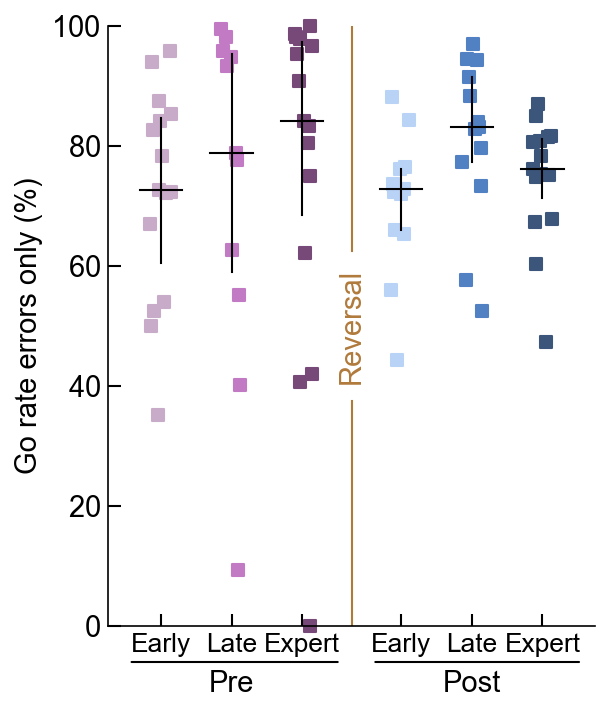

In [13]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
#fig,ax = make_axis_size(2.9, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2
#switch_offset = 0
################################################################################################################

#Plot figure

data = data_go_error
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    [q1,mean,q3] = np.percentile(Y,[25,50,75])
    
    SEM = sem(Y)

    
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s',clip_on=False)
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        # ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[q1,q3],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s',clip_on=False)
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        # ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[q1,q3],color='k',lw=1)

    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,100])
ylab = ax.set_ylabel('Go rate errors only (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\go error rate_trim.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [55]:
data_go = SimpleNamespace()
data_go.preearly = go_preearly_value
data_go.prelate = go_prelate_value
data_go.preexpert = go_preexpert_value
data_go.postearly = go_postearly_value
data_go.postlate = go_postlate_value
data_go.postexpert = go_postexpert_value
ilep.ttestindcompareall(data_go)

pre-early   n = 15
pre-late    n = 11
pre-expert  n = 15
post-early  n = 13
post-late   n = 13
post-expert n = 14
pre-early  to pre-late   : 0.8742540397638442
pre-late   to pre-expert : 0.3292335931725297
pre-early  to pre-expert : 0.23127742282891867
post-early to post-late  : 0.26035696338505454
post-late  to post-expert: 0.023219759213740292
post-early to post-expert: 0.16210863812811988


# Analysis of Outliers

In [4]:
df

,Unnamed: 0,animal,learning phase,hit rate,false alarm rate,go error rate,go rate
0,0,BS_40,pre early,57.246286,50.337639,52.567584,53.913705
1,1,BS_40,pre late,70.440753,50.510585,62.683105,60.729796
2,2,BS_40,pre expert,50.000000,0.000000,0.000000,28.301887
3,3,BS_40,post early,72.595621,78.595602,72.905214,75.523016
4,4,BS_40,post late,84.753950,77.204577,82.861301,81.091250
...,...,...,...,...,...,...,...
85,85,DS_19,pre late,99.615385,97.500000,99.574468,98.600000
86,86,DS_19,pre expert,95.221271,53.028067,90.875164,73.451444
87,87,DS_19,post early,58.690209,57.089408,55.944756,57.904876
88,88,DS_19,post late,82.716049,61.637931,77.297297,72.421053


In [7]:
df[df['go error rate'] < 40]

,Unnamed: 0,animal,learning phase,hit rate,false alarm rate,go error rate,go rate
2,2,BS_40,pre expert,50.000000,0.000000,0.000000,28.301887
18,18,BS_49,pre early,38.202600,34.853254,35.171242,36.596879
43,43,BS_59,pre late,46.296296,6.521739,9.375000,28.000000
